In [1]:
from time import perf_counter

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax
import equinox as eqx

from flex import FuzzyVariable
from flex.fiss import TSK

In [2]:
# Function to learn
f = lambda x, y: np.sin(x) * np.cos(y)

# Hyperparameters
N = 20000
batch_size = 2048
lr = 1e-1
epochs = 1000
val_frac = 0.2
optim = optax.adam(learning_rate=lr)

# Set random seed
seed = 12345
np.random.seed(seed)

# Generate training and validation data
X = np.random.uniform(-np.pi, np.pi, size=(N, 2))
Y = f(X[:, 0], X[:, 1])

_X = (X + np.pi) / (2.0*np.pi)  # intermediate scaling of inputs

# Shuffle and enforce validation split
idx = np.random.permutation(N)
n_val = int(N * val_frac)
val_idx, train_idx = idx[:n_val], idx[n_val:]

X_train = jnp.asarray(_X[train_idx])
Y_train = jnp.asarray(Y[train_idx])
X_val = jnp.asarray(_X[val_idx])
Y_val = jnp.asarray(Y[val_idx])

In [3]:
# Define batch iterator for training and validation
def batch_iterator(
        X,
        Y,
        batch_size,
        *,
        infinite=True,
        fill_batch=False,
):
    rng = np.random.default_rng(12345)

    xb_buf = None
    yb_buf = None
    buf_n = 0

    while True:
        idx = rng.permutation(len(X))
        X = X[idx]
        Y = Y[idx]

        n = len(X)
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)

            x_np = X[start:end]
            y_np = Y[start:end]
            m = end - start

            if not fill_batch:
                yield jnp.array(x_np), jnp.array(y_np)

            if xb_buf is None:
                xb_buf = x_np
                yb_buf = y_np
                buf_n = m
            else:
                xb_buf = np.concatenate([xb_buf, x_np], axis=0)
                yb_buf = np.concatenate([yb_buf, y_np], axis=0)
                buf_n += m

            while buf_n >= batch_size:
                xb = jnp.array(xb_buf[:batch_size])
                yb = jnp.array(yb_buf[:batch_size])
                yield xb, yb

                # keep leftovers in buffer
                if buf_n == batch_size:
                    xb_buf = None
                    yb_buf = None
                    buf_n = 0
                else:
                    xb_buf = xb_buf[batch_size:]
                    yb_buf = yb_buf[batch_size:]
                    buf_n -= batch_size

        if not infinite:
            break

    if fill_batch and buf_n > 0:
        yield jnp.array(xb_buf), jnp.array(yb_buf)

In [4]:
# Define model
def make_model(order: int) -> TSK:
    mfs = ["triangle"] * 7
    key = jax.random.PRNGKey(0)

    x = FuzzyVariable.manual(mfs=mfs, name="x")
    y = FuzzyVariable.manual(mfs=mfs, name="y")

    fis_name = f"TSK Order {order}"

    return TSK.init((x, y), order=order, name=fis_name, key=key, init_scale=0.5)

In [5]:
@eqx.filter_jit
def loss_fn(model, x, y):
    pred_y = model(x).squeeze()
    return jnp.mean((y - pred_y)**2)

@eqx.filter_jit
def step(model, x, y, opt_state):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state


In [ ]:
def train(model):
    train_loss = np.zeros(epochs)
    val_loss = np.zeros(epochs)

    opt_state = optim.init(model)

    min_val = np.inf
    best_model = None

    msg = f"Starting training on {model.name}"
    print(msg)
    print("-"*len(msg))
    for epoch in range(epochs):
        x_train, y_train = next(batch_iterator(X_train, Y_train, batch_size, fill_batch=True))
        x_val, y_val = next(batch_iterator(X_val, Y_val, batch_size, fill_batch=True))

        t0 = perf_counter()
        tl, model, opt_state = step(model, x_train, y_train, opt_state)
        vl = loss_fn(model, x_val, y_val)
        dt = perf_counter() - t0

        train_loss[epoch] = tl.item()
        val_loss[epoch] = vl.item()

        if val_loss[epoch] < min_val:
            min_val = val_loss[epoch]
            best_model = model
    
        print(f"epoch {epoch+1:02d}/{epochs} | train_loss={train_loss[epoch]:.4e} | val_loss={val_loss[epoch]:.4e} took {dt:.3e} seconds")

    print(f"{model.name} Training Complete!")
    return best_model, train_loss, val_loss

In [7]:
def test(model):
    return loss_fn(model, X_val, Y_val)

In [8]:
def viz_training(title, train_loss, val_loss):
    plt.title(title)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.legend()
    plt.show()

In [9]:
orders = [0, 1, 2]
titles = [None] * 3
models = [None] * 3

train_losses = np.zeros((len(orders), epochs))
val_losses = np.zeros((len(orders), epochs))
test_losses = np.zeros((len(orders),))

for order in orders:
    model = make_model(order)
    titles[order] = f"{model.name} Training History"

    best_model, tl, vl = train(model)
    train_losses[order, :] = tl
    val_losses[order, :] = vl

    test_losses[order] = test(best_model)
    # print(f"{best_model.name} test_loss={test_losses[order]:.4e}\n")

    models[order] = best_model

TSK Order 0 Training Complete!
TSK Order 1 Training Complete!
TSK Order 2 Training Complete!


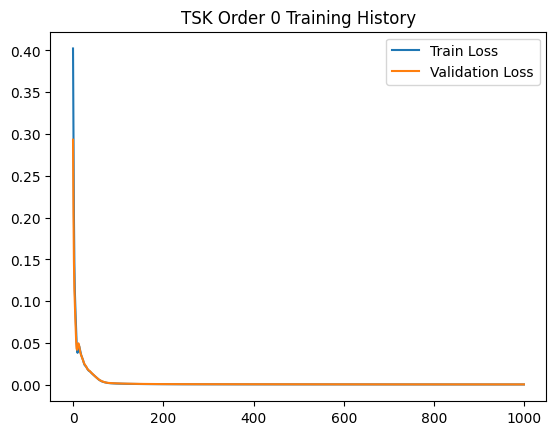

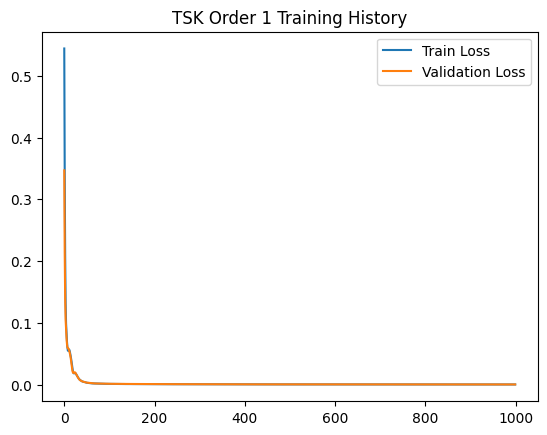

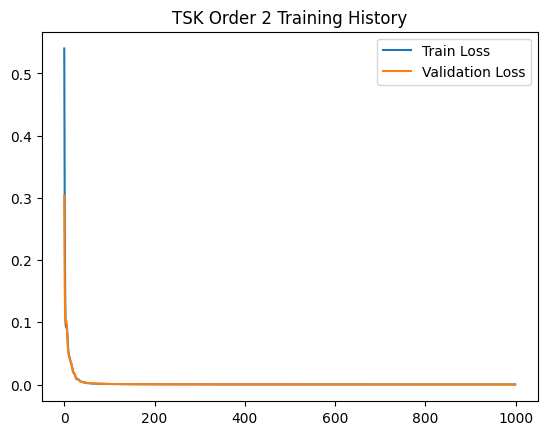

In [10]:
for i in range(len(titles)):
    viz_training(titles[i], train_losses[i, :], val_losses[i, :])

In [11]:
def count_parameters(model: eqx.Module) -> int:
    leaves = jax.tree_util.tree_leaves(
        eqx.filter(model, eqx.is_array)
    )
    return sum(leaf.size for leaf in leaves)

In [12]:
for model in models:
    print(f"{model.name} has {count_parameters(model)} parameters")

TSK Order 0 has 163 parameters
TSK Order 1 has 261 parameters
TSK Order 2 has 408 parameters
